In [1]:
import pyotm
import osmnx as ox
from itertools import product


In [50]:
bbox = {"north":14.6689, "south":14.6406, "east":121.0989, "west": 121.0480}
custom_filter = "['highway'~'primary|trunk|motorway|secondary|tertiary']"
crs = {"init":"epsg:32651"}

streets = pyotm.generator.extract_streets(bbox, crs=crs, custom_filter=custom_filter)

In [51]:
n, e = ox.save_load.graph_to_gdfs(streets)
node_id_map = dict(zip(n.index, range(len(n.index))))
n = n.reset_index()
n.gdf_name = "whatever"
e.u = e.u.apply(lambda x: node_id_map[x])
e.v = e.v.apply(lambda x: node_id_map[x])
e["link_id"] = list(range(e.shape[0]))
graph = ox.gdfs_to_graph(n, e)

In [52]:
graph = pyotm.preprocessing.add_speed_capacity(graph)

In [53]:
rc_id = 0
for node in graph.nodes:
    in_set = graph.in_edges(node)
    out_set = graph.out_edges(node)
    rc_set = []
    if (len(in_set) > 0) and (len(out_set) > 0):
        # Perform link product across nodes but remove u-turns,
        # i.e. links that map to the reverse direction
        node_rcs = [lkpair for lkpair in list(product(in_set, out_set)) if lkpair[0] != lkpair[1][::-1]]
        for i in node_rcs:
            rc_set += [{
                'rc_id': rc_id,
                'link_id_pair': [graph.get_edge_data(*i[0])[0]['link_id'],
                                 graph.get_edge_data(*i[1])[0]['link_id']],
                'in_lanes': graph.get_edge_data(*i[0])[0]['lanes'],
                'out_lanes': graph.get_edge_data(*i[1])[0]['lanes']
            }]
            rc_id += 1
    graph.nodes[node]['node_rcs'] = rc_set



In [54]:
rdparams = {}
rdparam_id = 0
for edge in graph.edges:
    edge_data = graph.get_edge_data(*edge)
    if (edge_data["capacity_lane_hour"], edge_data["speed"]) not in rdparams:
        rdparams[(edge_data["capacity_lane_hour"], edge_data["speed"])] = rdparam_id
        rdparam_id += 1
    graph.edges[edge]['rdparam_id'] = rdparams[(edge_data["capacity_lane_hour"], edge_data["speed"])]

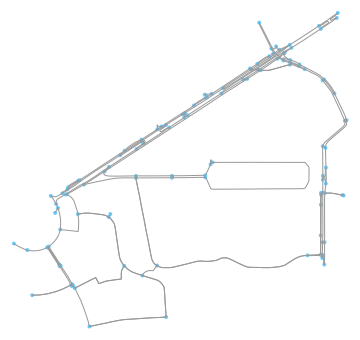

(<Figure size 446.66x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1e9e8f98>)

In [55]:
ox.plot_graph(graph)

In [49]:
graph.edges(data=True)

OutMultiEdgeDataView([(0, 1, {'geometry': <shapely.geometry.linestring.LineString object at 0x1a19080358>, 'highway': 'trunk_link', 'lanes': 2, 'length': 100.21900000000001, 'link_id': 0, 'oneway': True, 'osmid': 568988341, 'lanes_capped': 2, 'speed': 45, 'capacity_lane_hour': 2000, 'rdparam_id': 0}), (0, 41, {'geometry': <shapely.geometry.linestring.LineString object at 0x1a19080390>, 'highway': 'trunk_link', 'lanes': 2, 'length': 94.61999999999999, 'link_id': 1, 'name': 'U-Turn Slot', 'oneway': True, 'osmid': [670821747, 670821748, 158011980], 'lanes_capped': 2, 'speed': 45, 'capacity_lane_hour': 2000, 'rdparam_id': 0}), (1, 5, {'geometry': <shapely.geometry.linestring.LineString object at 0x1a190803c8>, 'highway': 'trunk', 'lanes': 9, 'length': 76.096, 'link_id': 2, 'maxspeed': 60.0, 'name': 'Commonwealth Avenue', 'oneway': True, 'osmid': 569325548, 'ref': '170', 'lanes_capped': 4, 'speed': 60, 'capacity_lane_hour': 2000, 'rdparam_id': 1}), (2, 46, {'geometry': <shapely.geometry.lin